In [1]:
import astropy.io.fits as fits
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import scipy.special as spec
warnings.filterwarnings("ignore")
from itertools import cycle
from scipy.interpolate import interp1d
import weave
from weave import converters

The particle files sent by Gerard Lemson unfortunately uses a naming convention for files according to the line number in the list of halos I sent him. So re read in a file which we can use to convert line numbers to HaloIds:

In [3]:
filename = '/nfs/Christoq1/MILLENNIUM/100Halos/particles/cmiller.csv'
dt = [('HaloId', long),('snapnum',long), ('px',float), ('py',float),('pz',float)]
cmiller_halos =  np.loadtxt(filename, dtype=dt,usecols = [0,1,2,3,4],delimiter=',',skiprows=1)
filenum = np.arange(100)


The halo information file was accessed through a series of queries to GAVO. See C Miller for more info. We read it in.

In [5]:
dt = [('HaloId', long),('subhaloid',long),('ra',float),('dec',float),('z',float),('r200crit',float),('m200crit',float),('angulardistance',float),('vdispmean',float),('px',float),('py',float),('pz',float),('vx',float),('vy',float),('vz',float),('r200mean',float),('m200mean',float)]
filename = '/nfs/Christoq1/MILLENNIUM/100Halos/biglosclusters.csv'
biglos =  np.loadtxt(filename, dtype=dt,delimiter=',',skiprows=1) 

Because we are using a lightcone, the clusters are all at different redshifts. We can match a cluster in the lightcone to a halo in the original particle output snapshots with its snapnum. We read it in.

In [6]:
dt = [('snap', long),('snapa', long), ('snapz',float)]
filename = '/nfs/Christoq1/MILLENNIUM/100Halos/snap_z_rev.dat'
snap =  np.loadtxt(filename, dtype=dt,delimiter=' ') 

In [7]:
filename =  '/nfs/Christoq1/MILLENNIUM/100Halos/DensityFits/millenium_ein_concentrations.dat'
dt = [('HaloId',long), ('ein_conc',float), ('ein_conc_err',float),('ein_dens',float),('ein_dens_err',float),('ein_scal',float),('ein_scal_err',float),('norm_ein',float)]
density_prof =  np.loadtxt(filename, dtype=dt,skiprows=0) 

In [8]:
filename =  '/nfs/Christoq1/MILLENNIUM/100Halos/cmiller.csv'
dt = [('HaloId', long),('snapnum',int),('posx',float),('posy',float),('posz',float), ('radius',float)]
cluster_list = np.loadtxt(filename, dtype=dt,delimiter=',',skiprows=1) 

In [9]:
def MYEINASTO_PHI(x,A):
 z = A[3]
 # this is probably wong. I need to use the z of the snapshot.
 a_halo=1/(1+z)
 Omega_m = A[4]
 Omega_L = A[5]
 H0 = A[6]
 Ez = np.sqrt((Omega_m/( a_halo**3) + Omega_L + (1-Omega_m - Omega_L)/(a_halo**2.0)))
 Omega_mz= Omega_m*((1 + 0.0)**3) /(Ez**2.0)
 Omega_Lz = Omega_L / (Ez**2.0)
 q = Omega_mz/2.0 - Omega_Lz
 Hz = np.sqrt(H0**2.0*Ez**2.0)
 ein_dens = A[0]
 ein_conc = A[1]
 ein_scal = A[2]
 r = np.float64(np.arange(1e5)/10.0)
 s = r/ein_scal
 Mtot = 4.0*np.pi*ein_dens*(ein_scal**3.0)*ein_conc*spec.gamma(3.0*ein_conc)   
 part1= 1.0 - spec.gammaincc(3*ein_conc,s**(1/ein_conc))
 part2=  s*(1.0e0 - (1-spec.gammaincc(2*ein_conc,s**(1/ein_conc))))* (spec.gamma(2*ein_conc) ) /spec.gamma(3*ein_conc)
 phi_ein_orig =  Mtot/(ein_scal*s)*(part1+part2)
 result = interp1d(r[1:310],phi_ein_orig[1:310])(x[1:])
 phi_ein = 6.673e-11/(1000**3.0)*result*1.989e30/3.08567758e19
 re2 = (( (6.673e-11/((1000.*3.08567758e19)**3.0)*(Mtot*1.989e30) ) /( -q*((Hz*3.24077e-20)**2.0)))**0.33)
 wr2_vescmax = np.where(np.abs(re2 - x) < 0.05)[0]
 phi_re2 = phi_ein[wr2_vescmax]
 lambda_add2 = q*((Hz*3.24077e-20)**2.0)*( (x[1:]*3.08567758e19)**2.0 - ((re2*3.08567758e19)**2.0) )
 phi_ein_keep = np.sqrt(2*phi_ein -2*phi_re2[0]  - lambda_add2)
 return phi_ein_keep


In [10]:
def Pick_pos(halop):
    x = np.random.uniform(-1,1)
    y = np.random.uniform(-1,1)
    z = np.random.uniform(-1,1)
    unit = np.array([x,y,z])/(x**2+y**2+z**2)**(.5)
    return unit

In [11]:
code = """
       int u,w;
       for (u=0;u<n;++u){
       for(w=0;w<3;++w){
           gal_pos_vect(w,u) = (gal_p(w,u)-new_pos(w))/gal_dist(u);
           }
       gal_vlos(u) = gal_pos_vect(0,u)*gal_v(0,u)+gal_pos_vect(1,u)*gal_v(1,u)+gal_pos_vect(2,u)*gal_v(2,u);
       }
       """


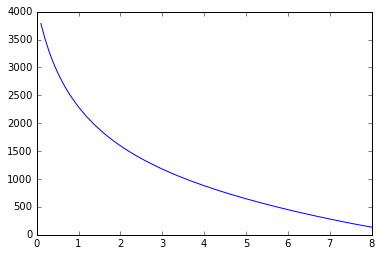

In [12]:
x = np.linspace(0,9.95,200) + 0.05
doit = np.where(density_prof['HaloId'] == 286006293000006)[0]
doit2 = np.where(biglos['HaloId'] == 286006293000006)[0]
result = MYEINASTO_PHI(x,[density_prof['ein_dens'][doit],density_prof['ein_conc'][doit], density_prof['ein_scal'][doit],biglos['z'][doit2],0.25,0.75,100])
plt.plot(x[1:],result)
plt.xlim(0,8)
plt.show()

In [13]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

286006293000006
6.3419812e+14 1.3435242397


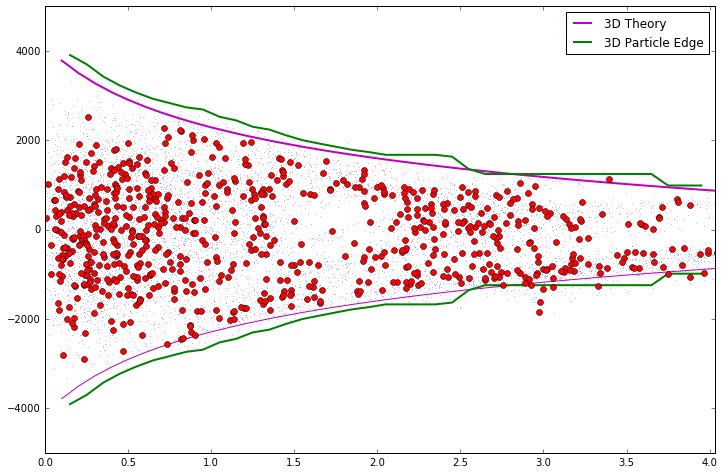

0.169244312322
[ 1693.49693779  1572.79952091  1178.33401748   742.35280308   506.46581725
   394.38991606   343.30867889   289.08399846   227.25746456   191.34908661
   260.94613132   244.51517541   259.98540628   261.79158199   248.8153354
   256.53844951   269.66907047   269.83938265   276.28397418   269.67491329
   281.34489631   273.23273904   285.14738466   301.6446214    330.25239359
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            na

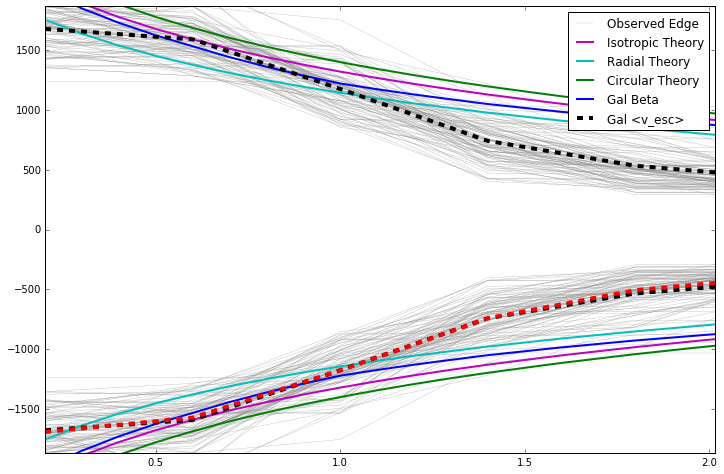

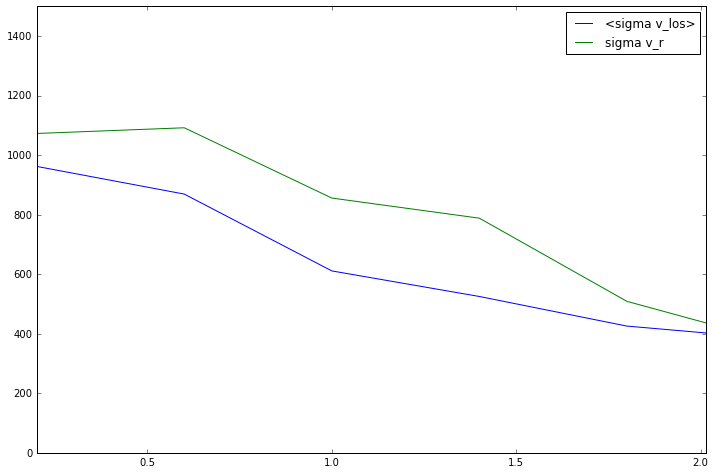

437005148000006
8.27648e+14 1.46820111798


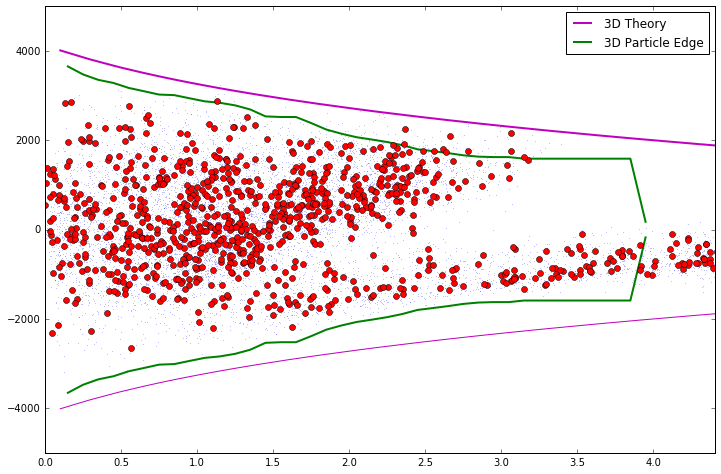

0.172723379901
[ 1797.53912423  1836.45417608  1527.93983037  1165.08039756   998.73496867
   871.63515411   527.07574763   296.16117023   251.68767654   191.83382952
   291.01911551   349.47755048   325.08808237   305.7430363    305.61367154
   245.76906354   286.28613837   269.86529708   275.40757958   253.91066836
   244.50314725   278.23245416   238.07510447   216.93944427   218.24036365
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            n

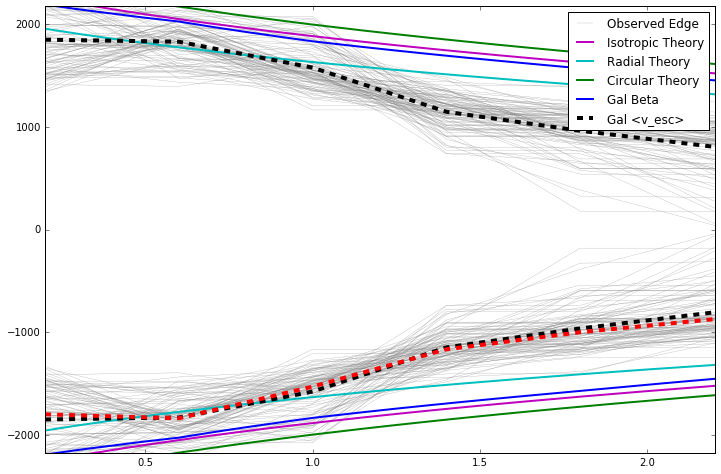

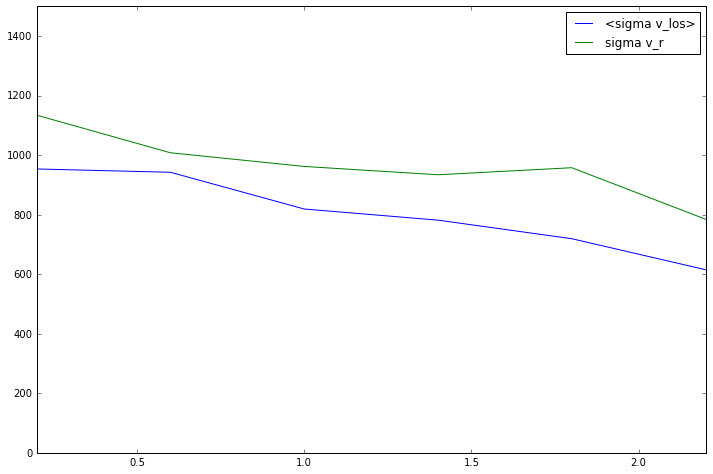

226000078000005
2.3990375e+14 0.979654856289


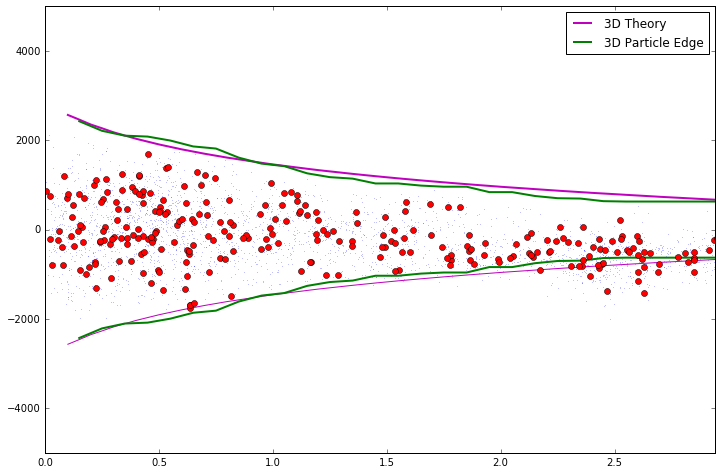

0.171246387101
[ 1472.94732865  1379.88706706  1197.91378999   362.672159     259.58287002
   218.40168313   183.20890541   158.45240645   156.3124069    149.57809881
   403.72309361   458.6248055    422.63978038   447.30872403   495.39833454
   488.59382308   518.97806328   504.51162076   519.20421064   565.90124687
   528.82015864   565.42024863   557.95697895   565.32322887   552.8505956
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            na

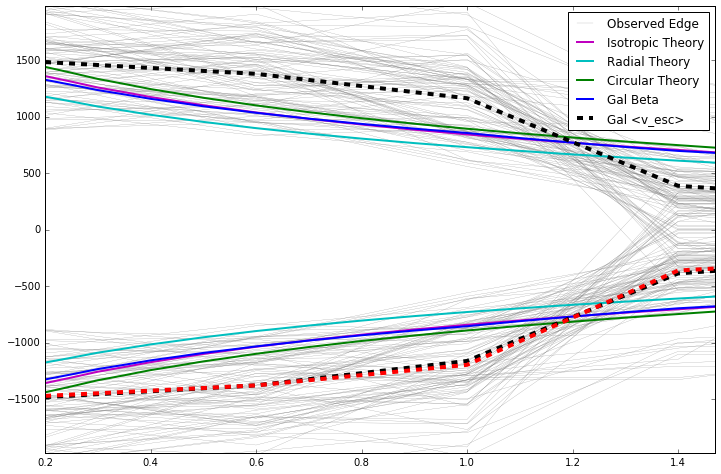

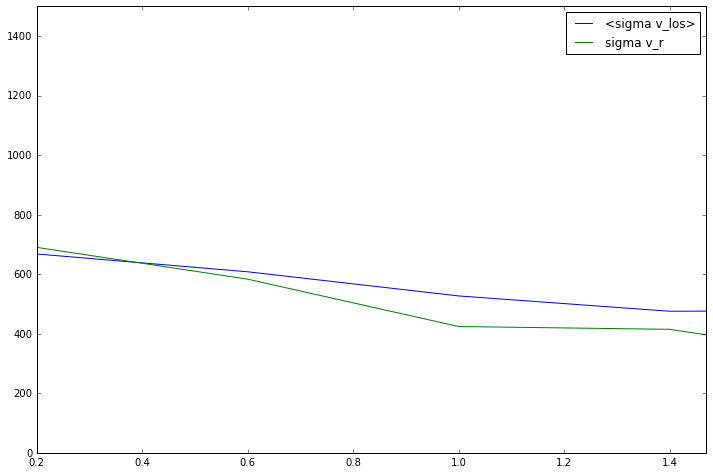

103000102000720
3.7289758e+14 1.1348133272


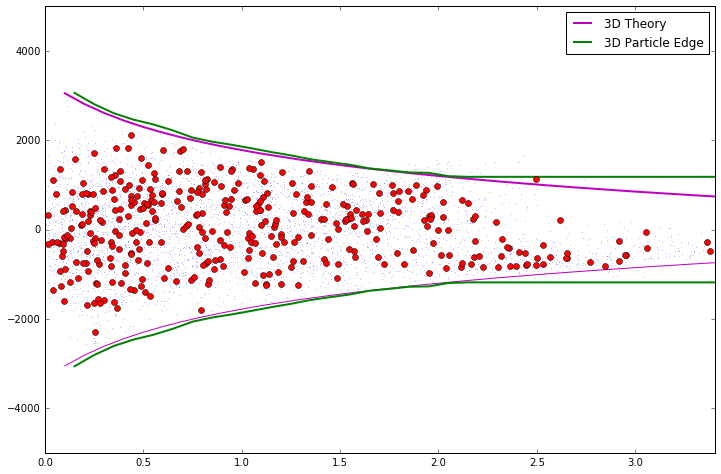

0.168694107071
[ 1615.61424293  1497.52170154  1279.4973525    617.60931661   474.73110743
   297.47922762   225.42647924   193.96191312   193.96191312   181.43739437
   419.30181563   430.74729477   471.33238092   445.98386316   465.12686294
   481.34488919   463.16164565   487.55534356   495.79265718   489.94583031
   478.8841181    473.77715164   444.58094161   424.48393272   381.80431456
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            n

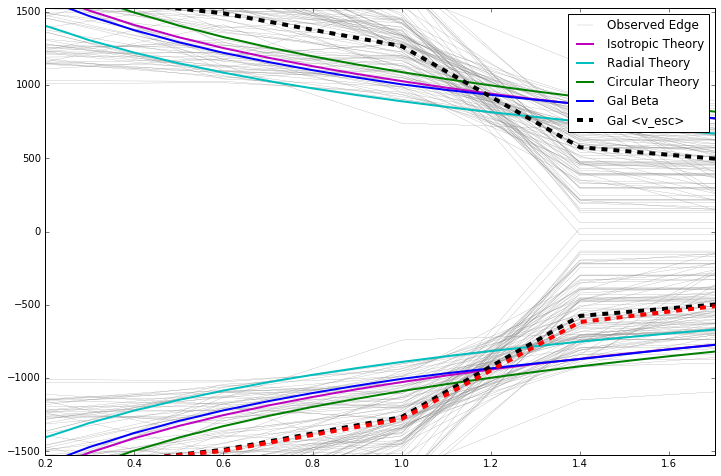

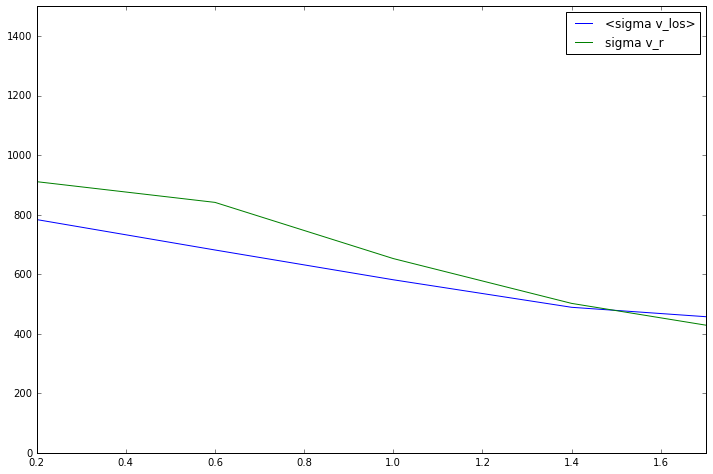

407000570000005
3.3723715e+14 1.09741791926


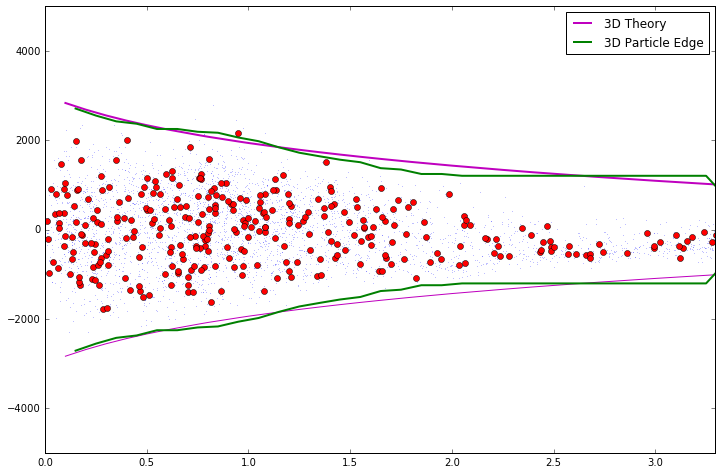

0.169768776146
[ 1429.06732838  1321.90534163  1170.78509821   564.24537756   416.1483245
   362.21515756   295.73852161   262.23061407   226.95214977   187.57026965
   495.68832199   484.44961273   478.82021147   528.31936278   524.95643433
   500.51975945   493.02833889   542.96842093   528.4647792    555.58881518
   521.49777027   502.20285159   472.98993595   439.73533108   473.41984222
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            na

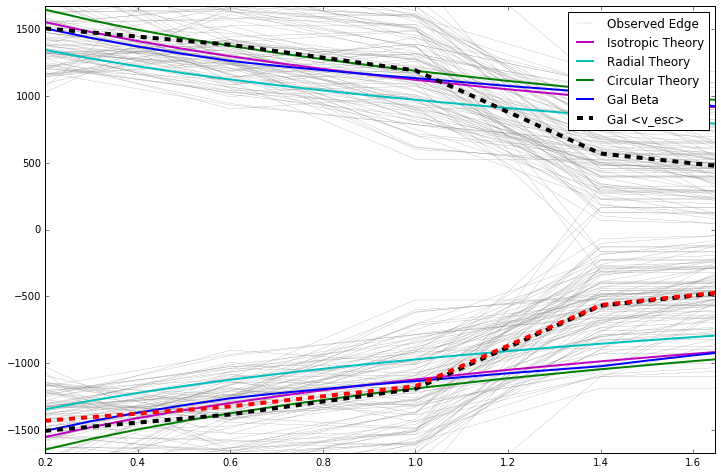

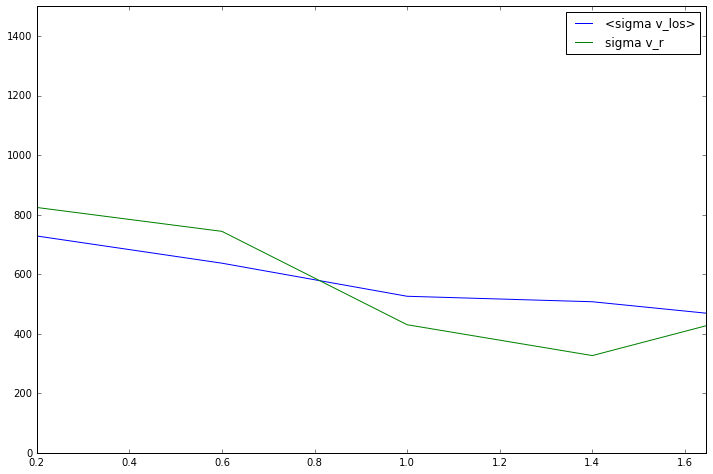

285006846019304
6.673765e+14 1.37779668657


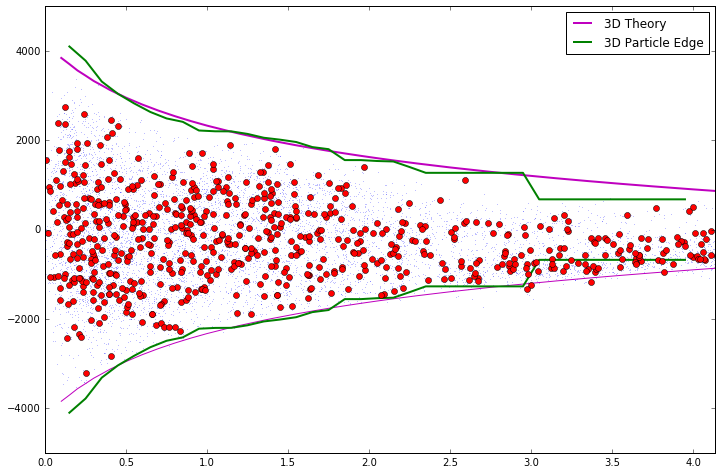

0.170146112244
[ 1961.97207534  1536.8875121   1302.6856316    844.81106593   598.80638308
   440.13790384   324.71849505   299.25666877   263.79273534   240.21405979
   348.05206021   337.18753246   317.4136083    320.89962921   301.75708581
   289.55818984   272.75652114   300.03411036   269.5168501    297.67474905
   276.21700814   291.97735974   287.7133448    289.38860295   301.08833446
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            n

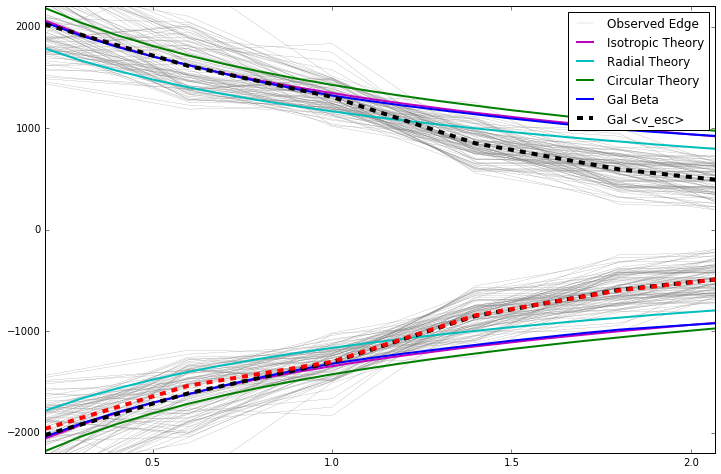

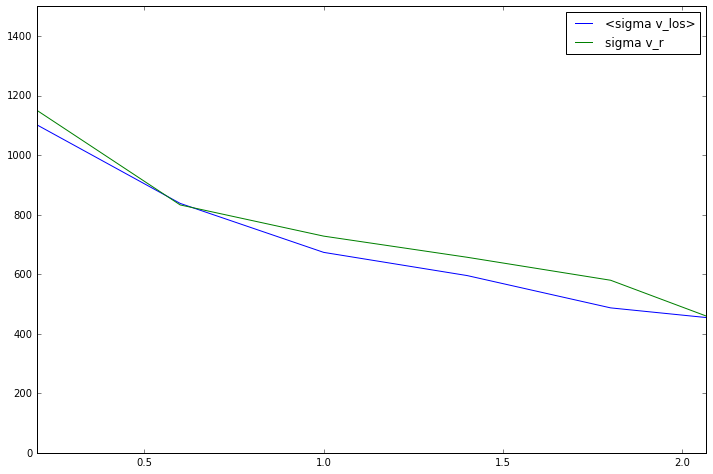

104000023005764
1.4826791e+14 0.834464365888


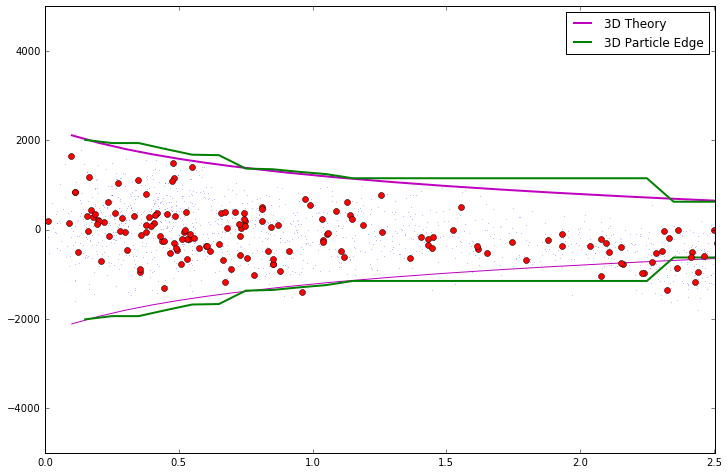

0.170947970339
[ 1437.222015    1436.91355136  1394.35886476   447.78034087   375.09257497
   348.72131047   315.0444164    288.83530548   255.81054195   236.26406207
   652.26173411   649.74315098   668.7605343    606.69932766   571.30179462
   542.14966023   538.28300821   546.27452448   520.54224773   524.73485426
   488.40696175   477.55771785   484.63368327   468.04748153   487.68864892
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            n

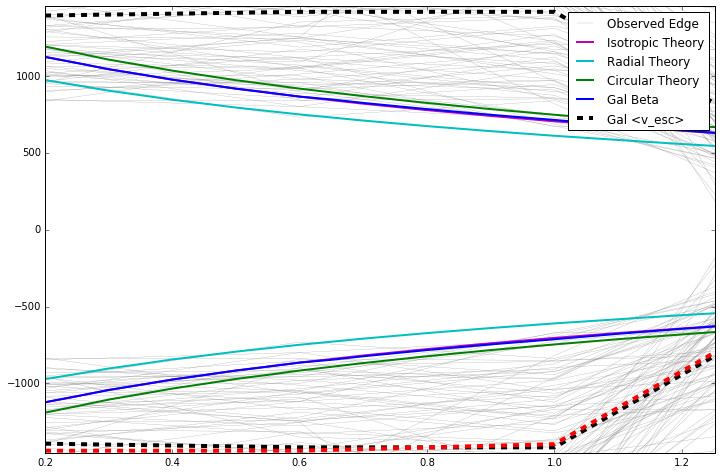

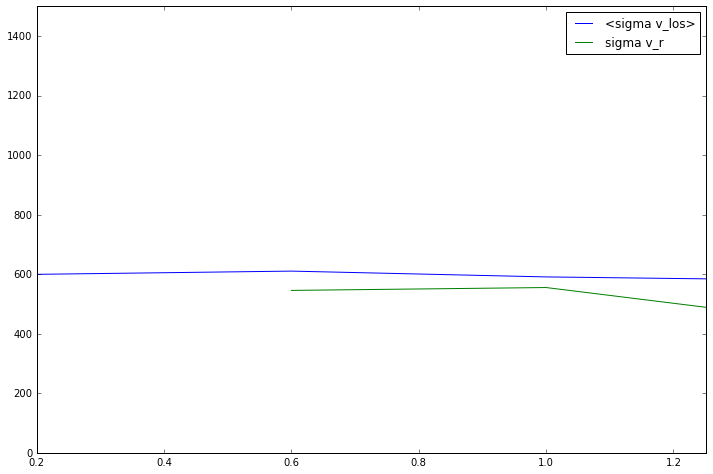

124000068000005
1.9810768e+14 0.919096804952


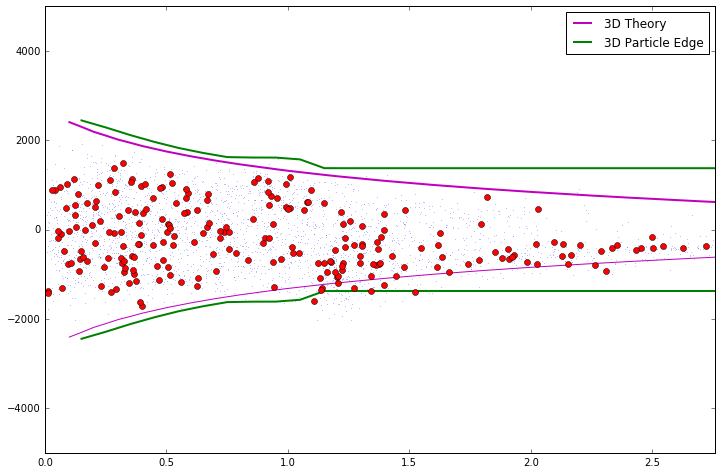

0.170413980332
[ 1675.8484972   1381.86118541  1230.93386396   445.91918189   340.99785792
   290.63032373   271.47982486   250.19574716   229.75965218   218.1019155
   637.20471891   673.06532256   644.6317791    650.13075538   680.97558728
   632.7756777    600.95879106   628.06808327   596.90823502   596.47508948
   616.18152022   594.12681954   530.86616347   501.59225774   426.17396439
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            nan
            nan            nan            nan            nan            na

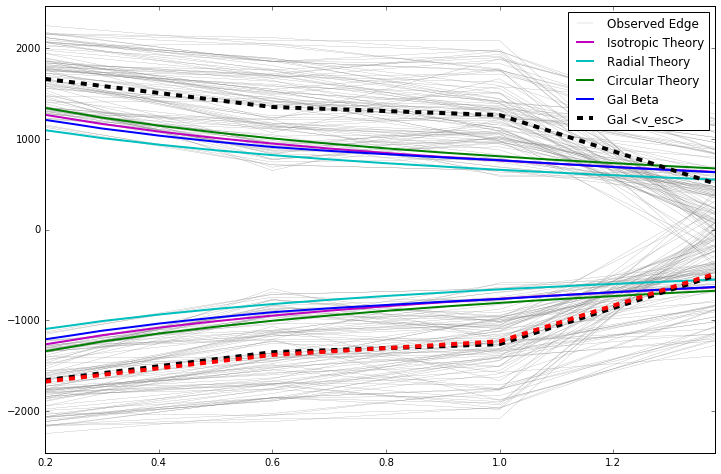

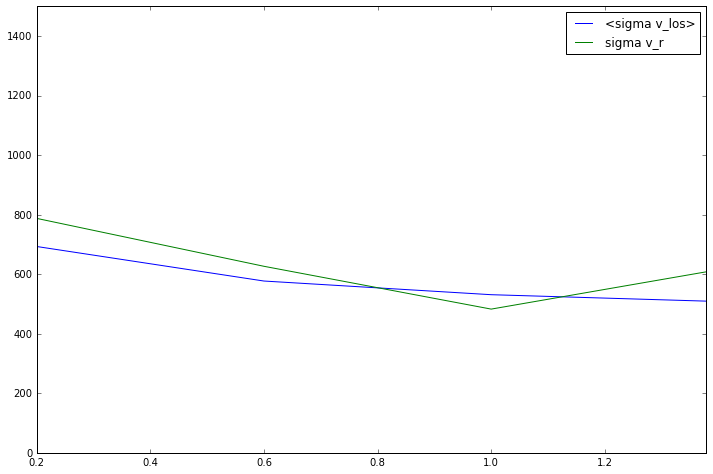

154000061000005
4.731417e+14 1.22854681002


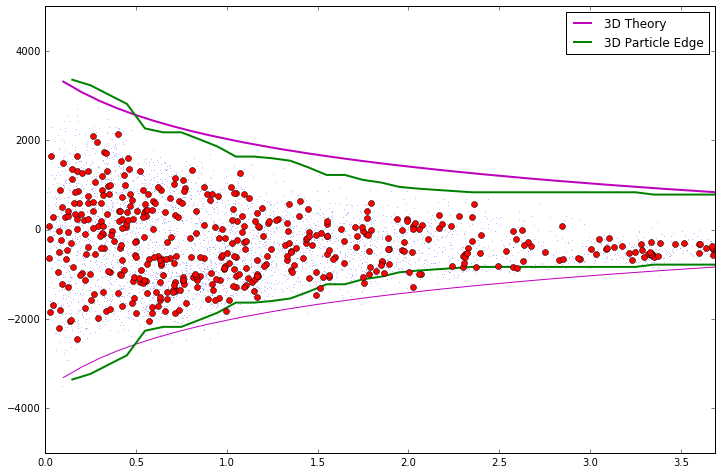

0.168948376614


KeyboardInterrupt: 

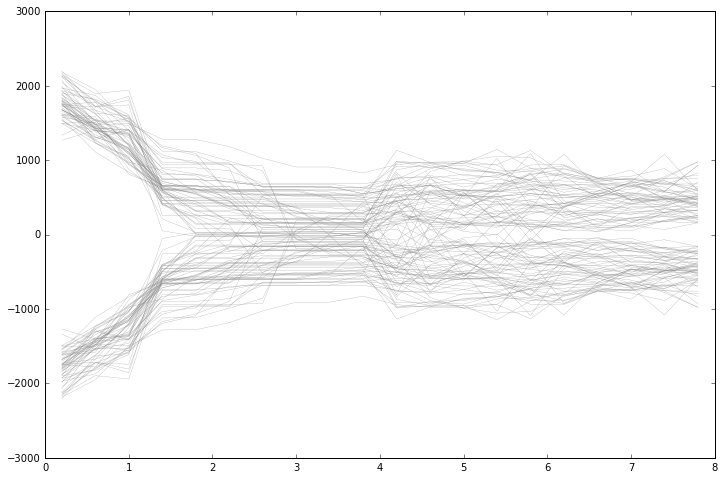

In [27]:
Omega_m = 0.25
Omega_L = 0.75
H0 = 100.0
r200 = np.zeros(100)
m200 = np.zeros(100)
bary_mass = np.zeros(100)
bary_frac = np.zeros(100)
sizempc = 10.e0
binsmpc = 100.e0
v_at_vescmax4 = np.zeros((int(binsmpc)-1,100))
vt_vescmax = np.zeros((int(binsmpc)-1,100))
vp_vescmax = np.zeros((int(binsmpc)-1,100))
v2_vescmax = np.zeros((int(binsmpc)-1,100))
v3d_vescmax = np.zeros((int(binsmpc)-1,100))
gal_v2_vlos = np.zeros((int(binsmpc)-1,100))
beta = np.zeros((int(binsmpc)-1,100))
g_beta = np.zeros((int(binsmpc)-1,100))
gal_vt_vescmax = np.zeros((int(binsmpc)-1,100))
gal_vp_vescmax = np.zeros((int(binsmpc)-1,100))
gal_v2_vescmax = np.zeros((int(binsmpc)-1,100))
gal_v3d_vescmax = np.zeros((int(binsmpc)-1,100))
gal_vratio_vescmax  = np.zeros((int(binsmpc)-1,100))
gal_beta = np.zeros((int(binsmpc)-1,100))
gal_g_beta = np.zeros((int(binsmpc)-1,100))
gal_v_at_vescmax4_tot = np.zeros((int(binsmpc)-1,100))
gal_v_at_vescmax4_cnt = np.zeros((int(binsmpc)-1,100))

gal_v_at_vescmax4 = np.zeros((int(binsmpc)-1,100,100))
r_vescmax = np.zeros((int(binsmpc)-1,100))
gal_r_vescmax = np.zeros((int(binsmpc)-1,100))


PLOTIT = 1

root_part = '/nfs/Christoq1/MILLENNIUM/100Halos/particles/'
root_guo = '/nfs/Christoq1/MILLENNIUM/100Halos/30Mpchalos/'

for i in range(len(cluster_list['HaloId'])):
    fig, axs = plt.subplots(ncols=1, figsize=(12, 8))  
    w = np.where(cluster_list['HaloId'][i] == biglos['HaloId'])
    www = np.where(cluster_list['HaloId'][i] == density_prof['HaloId'])
    wwww = np.where(cluster_list['snapnum'][i] == snap['snap'])
    a_halo = 1.0/(1+float(snap['snapz'][wwww]))
    print cluster_list['HaloId'][i]
    a_halo =1.0/(1+(snap['snapz'][wwww])) # Calculate the scale factor at the redshift of the cluster
    Ez = np.sqrt((Omega_m/( a_halo**3) + Omega_L + (1-Omega_m - Omega_L)/(a_halo**2.0))) # calculate Ez
    Omega_Lz = Omega_L / (Ez**2.0) #Evolve Omega_L
    Omega_mz = 1 - Omega_Lz #Evolve Omega_m
    q = Omega_mz/2.0 - Omega_Lz #Calculate qz
    Hz = np.sqrt(H0**2.0*Ez**2.0) #Calculate Hz
    r200[i] =  biglos['r200crit'][w]*a_halo # Maybe use this?
    m200[i] =  biglos['m200crit'][w]*(1e10)
    print m200[i], r200[i]
# First, get the particles
    filename = '/nfs/Christoq1/MILLENNIUM/100Halos/particles//t' + str(i) + '_cmiller.dat.fits' # Read in the particle data, where the particle positions have been recentered to the location of the cluster
    particles = fits.getdata(filename)
    ppx = particles['ppx']*a_halo # convert to physical coords
    ppy = particles['ppy']*a_halo
    ppz = particles['ppz']*a_halo
    rpart = np.sqrt(ppx**2.0 + ppy**2.0 + ppz**2.0) # calculate particle radii
    vvx = particles['vvx'] - np.mean(particles['vvx'][np.where(rpart < biglos['r200crit'][w])]) #move the particle velocities to be w/respect to the mean within r200crit
    vvy = particles['vvy'] - np.mean(particles['vvy'][np.where(rpart < biglos['r200crit'][w])])
    vvz = particles['vvz'] - np.mean(particles['vvz'][np.where(rpart < biglos['r200crit'][w])])
    vpart = np.sqrt((vvx)**2.0 + (vvy)**2.0 + (vvz)**2.0)
    thetavec = np.arccos(ppz/np.sqrt(ppx**2.0 + ppy**2.0 + ppz**2.0))
    phivec = np.arctan2(ppy,ppx)
    vtheta = vvx*np.cos(thetavec)*np.cos(phivec) + vvy*np.cos(thetavec)*np.sin(phivec) + vvz*np.sin(thetavec)
    vphi = -vvx*np.sin(phivec) + vvy*np.cos(phivec)
    vrad = vvx*ppx/ rpart + vvy*ppy/rpart + vvz*ppz/rpart # calculate the radial component of the velocities
    vflow = Hz*rpart
    vr_tot = vrad + vflow # Add in the Hubble flow
    vr_use = vr_tot
    rand_vec = (np.random.random_integers(0,len(rpart)-1,np.min([100000,len(rpart)-1]))) # Don't plot all particles if more than 100000
    if PLOTIT:
        x = np.linspace(0,19.95,400) + 0.05
#        print [density_prof['ein_dens'][doit],density_prof['ein_conc'][doit], density_prof['ein_scal'][doit],biglos['z'][halo_match]]
        result = MYEINASTO_PHI(x,[density_prof['ein_dens'][www],density_prof['ein_conc'][www], density_prof['ein_scal'][www],biglos['z'][wwww],0.25,0.75,100])
        plt.plot(rpart[rand_vec], vr_tot[rand_vec], '.',ms=0.3)
        plt.plot(x[1:],result,'m', label='3D Theory', linewidth=2)
        plt.plot(x[1:],-result,'m')
        plt.xlim(0,3*r200[i] )
        plt.ylim(-5000,5000)
    for j in range(0,int(binsmpc/2) - 1):
        r_vescmax[j,i] = float(j)/sizempc+0.05
        wpart = np.where((rpart > float(j)/sizempc) & (rpart <= float(j+1)/sizempc))[0]
        npart = len(wpart)
        rad_usorted = np.sort(vr_tot[wpart])
        rad_lsorted = np.sort(vr_tot[wpart])
        w_upper = rad_usorted[long(len(rad_usorted)*0.9999):len(rad_usorted)-1]
        w_lower = rad_lsorted[0:long(len(rad_lsorted)*0.0001)]
        tmp1 = np.median(rad_usorted[long(len(rad_usorted)*0.9999):len(rad_usorted)-1])
        tmp1b = np.median(rad_lsorted[0:long(len(rad_lsorted)*0.0001)])
#        print tmp1, tmp1b
        if (j <= 2):
            v_at_vescmax4[j,i] = np.max([abs(tmp1b),tmp1])
        else:
            if (np.min([np.abs(tmp1b),tmp1]) <= v_at_vescmax4[j-1,i]):
                v_at_vescmax4[j,i] = np.min([np.abs(tmp1b),tmp1])
            else:
                v_at_vescmax4[j,i] =  v_at_vescmax4[j-1,i]
        v2_vescmax[j,i] = np.var((vr_tot[wpart]))
        vp_vescmax[j,i] = np.var((vphi[wpart]))
        vt_vescmax[j,i] = np.var((vtheta[wpart]))
        v3d_vescmax[j,i] = np.sqrt(np.power(v2_vescmax[j,i],2.0) + np.power(vp_vescmax[j,i],2.0) + np.power(vt_vescmax[j,i],2.0))
        beta[j,i] = 1 - (vt_vescmax[j,i] +  vp_vescmax[j,i])/2.0/v2_vescmax[j,i]
        g_beta[j,i] = (3-2*beta[j,i])/(1-beta[j,i])
                                                       
#    print beta[:,i]
    plt.plot(r_vescmax[1:40,i],v_at_vescmax4[1:40,i],'g', label='3D Particle Edge', linewidth=2)
    plt.plot(r_vescmax[1:40,i],-v_at_vescmax4[1:40,i],'g', linewidth=2)
    plt.legend()
    
# Next get the galaxies
    filename = str(cluster_list['HaloId'][i]) + '.Guo30.fits' # Read in the galaxy data (brighter than m=-18), where the galaxy positions have NOT been recentered to the location of the cluster
    galaxies = fits.getdata(root_guo + filename)
    ppx = (galaxies['x'] - biglos['px'][w])*a_halo # convert to physical coords
    ppy = (galaxies['y'] - biglos['py'][w])*a_halo
    ppz = (galaxies['z'] - biglos['pz'][w])*a_halo
    rgal = np.sqrt(ppx**2.0 + ppy**2.0 + ppz**2.0) # calculate particle radii
    vvx = galaxies['velX'] - np.mean(particles['vvx'][np.where(rpart < biglos['r200crit'][w])]) #move the particle velocities to be w/respect to the mean within r200crit
    vvy = galaxies['velY'] - np.mean(particles['vvy'][np.where(rpart < biglos['r200crit'][w])])
    vvz = galaxies['velZ'] - np.mean(particles['vvz'][np.where(rpart < biglos['r200crit'][w])])
    thetavec = np.arccos(ppz/np.sqrt(ppx**2.0 + ppy**2.0 + ppz**2.0))
    phivec = np.arctan2(ppy,ppx)
    vtheta = vvx*np.cos(thetavec)*np.cos(phivec) + vvy*np.cos(thetavec)*np.sin(phivec) + vvz*np.sin(thetavec)
    vphi = -vvx*np.sin(phivec) + vvy*np.cos(phivec)
    vrad = vvx*ppx/rgal + vvy*ppy/rgal + vvz*ppz/rgal # calculate the radial component of the velocities
    vflow = Hz*rgal
    vr_tot = vrad + vflow # Add in the Hubble flow
    members = np.where(rgal < biglos['r200crit'][w])[0]
    # Next, I will sum up all the baryonic mass within r200crit from the Guo files. I THINK this encompasses ALL of the baryons. It matches WMAP and what is in https://arxiv.org/pdf/1006.0106.pdf
    bary_mass[i] =  np.sum(galaxies['COLDGAS'][members] + galaxies['STELLARMASS'][members] + galaxies['hotgas'][members] + galaxies['ICMSTELLARMASS'][members] + galaxies['BLACKHOLEMASS'][members] + galaxies['EJECTEDMASS'][members])*1e10
    bary_frac[i] = bary_mass[i]/m200[i]
    if PLOTIT:
        plt.plot(rgal, vr_tot, 'ro',label='3D Galaxy Edge')  
        plt.show()
    print bary_frac[i]
    fig, axs = plt.subplots(ncols=1, figsize=(12, 8))  
    for m in range(0,100):
        maxm = np.zeros(1)
        Halo_V = np.array([np.mean(particles['vvx'][np.where(rpart < biglos['r200crit'][w])]), np.mean(particles['vvy'][np.where(rpart < biglos['r200crit'][w])]), np.mean(particles['vvz'][np.where(rpart < biglos['r200crit'][w])])])
        gal_v = np.array([vvx,vvy,vvz])
        gal_p = np.array([ppx,ppy,ppz])
        new_pos = 10*Pick_pos([0,0,0]) #Decide where the observer sits
        #derive halo information with new los
        halo_dist = ((new_pos[0])**2 + (new_pos[1])**2 + (new_pos[2])**2)**0.5
        halo_pos_vect = np.array([-new_pos[0],-new_pos[1],-new_pos[2]])/halo_dist
        halo_vlos = np.dot(halo_pos_vect, Halo_V)
        #derive galaxy information with new los
        gal_dist = ((ppx-new_pos[0])**2 + (ppy-new_pos[1])**2 + (ppz-new_pos[2])**2)**0.5
        gal_vlos = np.zeros(gal_dist.size)
        n = gal_dist.size
        gal_pos_vect = np.zeros((3,gal_dist.size))
        fast = weave.inline(code,['gal_pos_vect','n','gal_dist','gal_vlos','gal_v','new_pos','gal_p'],type_converters=converters.blitz,compiler='gcc')
#        print gal_pos_vect
#        plt.plot(gal_pos_vect[0,:],gal_pos_vect[1,:],'.',ms=0.2)
#        plt.plot(halo_pos_vect[0], halo_pos_vect[1],'x',ms=2)
#        plt.show()
        r = (halo_dist**2-np.dot(halo_pos_vect*halo_dist,gal_pos_vect)**2)**0.5
        v = gal_vlos-halo_vlos*np.dot(halo_pos_vect,gal_pos_vect)
#        plt.plot(r,v,'k.',ms=0.75)
#        plt.xlim(0,3)
        for j in range(0,int(binsmpc) - 1):
            gal_r_vescmax[j,i] = float(j)/sizempc/0.25+0.2
            wgal = np.where((r > float(j)/sizempc/0.25) & (r <= float(j+1)/sizempc/0.25))[0]
#            print  float(j)/sizempc/0.25, float(j+1)/sizempc/0.25,  gal_r_vescmax[j,i]
            ngal = len(wgal)
            rad_usorted = np.sort(v[wgal])
            rad_lsorted = np.sort(v[wgal])
            tmp1 = np.median(rad_usorted[long(len(rad_usorted)*0.90):len(rad_usorted)-1])
            tmp1b = np.median(rad_lsorted[0:long(len(rad_lsorted)*0.1)])
#            tmp1 = np.max(rad_usorted)+50
#            tmp1b = np.min(rad_lsorted)-50
#            print tmp1,tmp1b
            if (j <= 2):            
                tmp1 = np.median(rad_usorted[long(len(rad_usorted)*0.9):len(rad_usorted)-1])
                tmp1b = np.median(rad_lsorted[0:long(len(rad_lsorted)*0.1)])
                gal_v_at_vescmax4[j,i,m] = np.max([abs(tmp1b),tmp1])
                if (~np.isnan(np.max([abs(tmp1b),tmp1]))):
                   gal_v_at_vescmax4_tot[j,i] = gal_v_at_vescmax4_tot[j,i] + gal_v_at_vescmax4[j,i,m]
                   gal_v_at_vescmax4_cnt[j,i] = gal_v_at_vescmax4_cnt[j,i] + 1
            elif ((j >2) & (j<10)):
                tmp1 = np.median(rad_usorted[long(len(rad_usorted)*0.9):len(rad_usorted)-1])
                tmp1b = np.median(rad_lsorted[0:long(len(rad_lsorted)*0.1)])
                if (np.min([np.abs(tmp1b),tmp1]) <= gal_v_at_vescmax4[j-1,i,m]):
                    gal_v_at_vescmax4[j,i,m] = np.min([np.abs(tmp1b),tmp1])
                    if (~np.isnan(np.min([abs(tmp1b),tmp1]))):                           
                       gal_v_at_vescmax4_tot[j,i] = gal_v_at_vescmax4_tot[j,i] + gal_v_at_vescmax4[j,i,m]
                       gal_v_at_vescmax4_cnt[j,i] = gal_v_at_vescmax4_cnt[j,i] + 1
                else:
                    gal_v_at_vescmax4[j,i,m] =  gal_v_at_vescmax4[j-1,i,m]
                    if (~np.isnan(gal_v_at_vescmax4[j-1,i,m])):                                                                              
                        gal_v_at_vescmax4_tot[j,i] = gal_v_at_vescmax4_tot[j,i] + gal_v_at_vescmax4[j,i,m]
                        gal_v_at_vescmax4_cnt[j,i] = gal_v_at_vescmax4_cnt[j,i] + 1
            elif (j >= 10):
                tmp1 = np.median(rad_usorted[long(len(rad_usorted)*0.9):len(rad_usorted)-1])
                tmp1b = np.median(rad_lsorted[0:long(len(rad_lsorted)*0.1)])
                gal_v_at_vescmax4[j,i,m] = np.min([abs(tmp1b),tmp1])
                if (~np.isnan(np.min([abs(tmp1b),tmp1]))):                           
                       gal_v_at_vescmax4_tot[j,i] = gal_v_at_vescmax4_tot[j,i] + gal_v_at_vescmax4[j,i,m]
                       gal_v_at_vescmax4_cnt[j,i] = gal_v_at_vescmax4_cnt[j,i] + 1
                      
                    
            gal_v2_vescmax[j,i] = np.sqrt(np.var((vrad[wgal])))
            gal_vp_vescmax[j,i] = np.sqrt(np.var((vphi[wgal])))
            gal_vt_vescmax[j,i] = np.sqrt(np.var((vtheta[wgal])))
            gal_v3d_vescmax[j,i] = np.sqrt(np.power(gal_v2_vescmax[j,i],2) + np.power(gal_vp_vescmax[j,i],2) + np.power(gal_vt_vescmax[j,i],2) )
            gal_beta[j,i] = 1 - (gal_vt_vescmax[j,i] +  gal_vp_vescmax[j,i])/2.0/gal_v2_vescmax[j,i]
            gal_g_beta[j,i] = (3-2*gal_beta[j,i])/(1-gal_beta[j,i])
# We will average over 100 m lines-of-sight            
            gal_v2_vlos[j,i] = gal_v2_vlos[j,i] + np.sqrt(np.var((v[wgal])))
           
#        plt.plot(gal_r_vescmax[0:20,i],gal_v_at_vescmax4[0:20,i,m], 'grey',label='Edge', linewidth=2)
#        plt.plot(gal_r_vescmax[0:20,i],-gal_v_at_vescmax4[0:20,i,m], 'grey',linewidth=2)
#        plt.show()
        if (m == 1):
           plt.plot(gal_r_vescmax[0:20,i],gal_v_at_vescmax4[0:20,i,m], 'grey',label='Observed Edge', linewidth=0.2)
        plt.plot(gal_r_vescmax[0:20,i],gal_v_at_vescmax4[0:20,i,m], 'grey', linewidth=0.2)    
        plt.plot(gal_r_vescmax[0:20,i],-gal_v_at_vescmax4[0:20,i,m], 'grey',linewidth=0.2)
#        plt.show()
        total_max =  np.append(gal_v_at_vescmax4[0:20,i,m],maxm,0)
        maxm = np.max(total_max)

    
#    print x
#    print result
#    print gal_r_vescmax[0:20,i]
#    print beta[:,i]
    this_edge_median = np.zeros(100)
    for j in range(0,int(binsmpc) - 1):
#        print gal_v_at_vescmax4[j,i,:]
        this_edge1 = gal_v_at_vescmax4[j,i,:]
        this_edge = this_edge1[~np.isnan(this_edge1)]
        this_edge_median[j] = np.median(this_edge)
        
    print this_edge_median
    this_edge1 = gal_v_at_vescmax4_tot[:,i]
    this_edge = this_edge1[~np.isnan(this_edge1)]
    print this_edge/99.0
    gal_g_beta_int = np.interp(x,gal_r_vescmax[:,i],gal_g_beta[:,i])
    wherenan = np.isnan(gal_g_beta_int)
    replace =  np.full((len(wherenan[wherenan == True])),3.0)
    gal_g_beta_int[wherenan] = replace
    
    plt.plot(x[1:],result/np.sqrt(3.0),'m', label='Isotropic Theory',linewidth=2)
    plt.plot(x[1:],-result/np.sqrt(3.0),'m',linewidth=2)   
    plt.plot(x[1:],result/np.sqrt(4.0),'c', label='Radial Theory',linewidth=2)
    plt.plot(x[1:],-result/np.sqrt(4.0),'c',linewidth=2)   
    plt.plot(x[1:],result/np.sqrt(2.67),'g', label='Circular Theory',linewidth=2)
    plt.plot(x[1:],-result/np.sqrt(2.67),'g',linewidth=2)   
    plt.plot(x[1:],result/np.sqrt(gal_g_beta_int[1:]),'b', label='Gal Beta',linewidth=2)
    plt.plot(x[1:],-result/np.sqrt(gal_g_beta_int[1:]),'b',linewidth=2)   
    plt.plot(gal_r_vescmax[:,i],this_edge/100.0, 'k--', label='Gal <v_esc>',linewidth=4)
    plt.plot(gal_r_vescmax[:,i],-this_edge/100.0, 'k--',linewidth=4)
    plt.plot(gal_r_vescmax[:,i],-this_edge_median[0:99], 'r--',linewidth=4)
#    print this_edge
    plt.legend()    
    plt.xlim(0.2,1.5*r200[i] )
    plt.ylim(-maxm-300,maxm+300)
    plt.show()
    

    fig, axs = plt.subplots(ncols=1, figsize=(12, 8))  
    plt.plot(gal_r_vescmax[0:20,i],(gal_v2_vlos[0:20,i]/100.0), label='<sigma v_los>')
    plt.plot(gal_r_vescmax[0:20,i],gal_v2_vescmax[0:20,i], label='sigma v_r')
    plt.xlim(0.2,1.5*r200[i] )
    plt.ylim(0,1500)   
    plt.legend()
    plt.show()

fig, axs = plt.subplots(ncols=1, figsize=(12, 8))  
plt.plot(gal_r_vescmax[0:20,:], gal_v3d_vescmax[0:20,:] / (gal_v2_vlos[0:20,:]/100.0), label = 'v3d/vlos')
plt.legend()
plt.xlim(0.2,1.5*r200[i] )
plt.show()
   


In [ ]:
plt.plot(gal_r_vescmax[0:20,0], gal_v3d_vescmax[0:20,0] / (gal_v2_vlos[0:20,0]/100.0), label = 'v3d/vlos')
plt.plot(gal_r_vescmax[0:20,:], gal_v3d_vescmax[0:20,:] / (gal_v2_vlos[0:20,:]/100.0))
plt.legend()
plt.xlim(0.2,1.5*r200[i] )
plt.show()

In [ ]:
#print gal_v3d_vescmax[3:15,0]
#print gal_v2_vlos[3:15,0]/100.0
#print  (gal_v3d_vescmax[3:15,0] / (gal_v2_vlos[3:15,0]/100.0))
v_ratio = np.zeros((int(binsmpc/2.)-1,100))
for i in range(0,100):
  v_ratio[:,i] = (gal_v3d_vescmax[:,i] / (gal_v2_vlos[:,i]/100.0))
#print np.size(v_ratio)
v_ratio_flat = np.reshape(v_ratio[0:13,:],np.size(v_ratio[0:13,:]))
v_ratio_flat1 = v_ratio_flat[np.logical_not(np.isnan(v_ratio_flat))]
#print v_ratio_flat1
plt.hist(v_ratio_flat1,bins=100)
plt.show()

g_beta_flat = np.reshape(g_beta, np.size(g_beta))
gal_g_beta_flat = np.reshape(gal_g_beta[0:13,:], np.size(gal_g_beta[0:13,:]))
plt.plot(np.power(v_ratio_flat,2),gal_g_beta_flat, '.')
plt.xlim(0.5,6)
plt.ylim(2.0,4.5)
plt.show()